# Examples Exploring Fake Fraud Data Created by bluefaker_factory

These are examples using the `duckdb`, `seaborn` and `matplotlib` libraries. Make sure they are installed.
`pip install duckdb, seaborn, matplotlib` inside your environment. 

Querring the ***fake fruad data*** we just made in bluefaker_factory.




# Setting up:

1) #### ***Generate fake data based on the given fraud schema:***
Quick review of the schema logic. 

Here is a snippet of `schemas/fraud_schema.yml`


In the schema file `dtype` defines the data type for the column (e.g., string, int), while `faker_type` specifies how the fake data should be generated for that column.

```yaml
head schemas/fraud_schema.yaml

domains:
  - fraud

schema:
  - column: ID
    dtype: string
    faker_type: uuid4
  - column: Name
    dtype: string
    faker_type: name
  - column: Email
    dtype: string
    faker_type: email
    ...
```
The domains key triggers the domain logic in the `logic_modules/` directory. These are plugins you can create and add to extend or customize behavior.

```yaml
domains:
  - fraud
```

Some key features in the config: 

-  **nullable:** Adds messy/realistic data for testing by inserting nulls. The value represents the percentage of time nulls should be added. 

```yaml
  - column: Gender
    dtype: string
    faker_type: gender
    nullable: 30
```

- **options:** Acts like an enum. When used with random_element, it randomly picks one of the listed values.

```yaml
  - column: Card_Type
    dtype: string
    faker_type: random_element
    options: ["Visa", "MasterCard", "Amex", "Discover"]
```

2) #### ***Run*** `bluefaker.py`

There are some prepared wrapper script what will build the data set in scripts directory:

```bash
───────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────-
       │ File: scripts/create_fake_fraud_data.sh
───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1   │ python bluefaker.py --schema schemas/fraud_schema.yaml \
   2   │                           --records 100000 \
   3   │                           --format parquet \
   4   │                           --file data/raw/fraud_data01
───────┴────────────────────────────────────────────────────────────────

```


***Run the script:***

```bash
(.venv) ➜  bluefaker_factory> bash scripts/create_fake_fraud_data.sh

Generating Fake Data with '100000' records....

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4163.31it/s]
```
```bash
Sample Data:
+--------------------------------------+---------------+-------------------------------+------------+-----+------------+--------------+---------------+------------+--------------------+----------------------+---------------------------------------------------------------------------+
|                  ID                  |      Name     |             Email             |   Gender   | Age |  Country   | Credit_Score | Annual_Income | Card_Type  | Transaction_Amount | Transaction_Location |                                                                       Device                                                                       | Time_Of_Day | Fraudulent |
+--------------------------------------+---------------+-------------------------------+------------+-----+------------+--------------+---------------+------------+--------------------+----------------------+---------------------------------------------------------------------------+
| 5b107e24-e44f-40a5-8af3-3cb82de6db78 |  Brooke Shea  | brooke.shea@savage-gordon.com | Non-binary |  74 | Bangladesh |     750      |     94869     | MasterCard |       707.46       |     Browningfort     | Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like Mac OS X; th-TH) AppleWebKit/533.31.3 (KHTML, like Gecko) Version/3.0.5 Mobile/8B112 Safari/6533.31.3 |   00:56:15  |   False    |
| 3190e7d9-059d-46fb-b04f-740f166be14b | Robert Thomas |    robert.thomas@hayes.com    |    Male    |  22 |  Lebanon   |     470      |     155591    |    Amex    |       962.78       |      Silvafurt       |    Mozilla/5.0 (iPhone; CPU iPhone OS 13_5_1 like Mac OS X) AppleWebKit/535.2 (KHTML, like Gecko) FxiOS/15.1l2332.0 Mobile/52O482 Safari/535.2     |   13:08:15  |    True    |
| 5844d3d9-f3c3-4fd0-b52b-20226cb1249c |  Kelly Perry  |     kelly.perry@hanson.com    |   Female   |  32 |  Colombia  |     300      |     93419     | MasterCard |       210.06       |     Kevinchester     |                                          Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/5.1)                                           |   13:21:40  |   False    |
+--------------------------------------+---------------+-------------------------------+------------+-----+------------+--------------+---------------+------------+--------------------+----------------------+---------------------------------------------------------------------------+

Created file: data/raw/fraud_data01.parquet
Number of rows added: 100000

```
#### You have the option to run directly to change values:

```
python bluefaker.py --schema schemas/fraud_schema.yaml \
                    --records 10 \
                    --format csv \
                    --file data/raw/fraud_sample
```

3) #### **Initiallize Duckdb and create a table from our fraud file we created.**

Bellow I show both Persisted (Disk) and In-Memory approaches with DuckDB: 

- **Persist to Disk:** Use this when you want to save the database and reuse it later (e.g., across sessions or scripts):
- **In Memory:** Use this when you want speed and simplicity, and don’t need to keep the data: ***Note Be Aware of Data Size***

In [2]:
import duckdb

# Setting a persisted database on disk
#con = duckdb.connect("data/database/jupyter_play.db")
# or 
con = duckdb.connect(database=":memory:")

# Creating a Table from parquet file
con.execute("""
    CREATE OR REPLACE TABLE fraud_data AS 
    SELECT * FROM read_parquet('data/raw/fraud_data01.parquet')
""")

row_count = con.execute("SELECT COUNT(*) FROM fraud_data").fetchone()[0]
print("Row Count:", row_count)

Row Count: 100000


## Quick Discovery of the Generated Data

### Table Definitions:

In [3]:
con.sql("PRAGMA table_info(fraud_data)").df()

,cid,name,type,notnull,dflt_value,pk
0,0,ID,VARCHAR,False,None,False
1,1,Name,VARCHAR,False,None,False
2,2,Email,VARCHAR,False,None,False
3,3,Gender,VARCHAR,False,None,False
4,4,Age,BIGINT,False,None,False
5,5,Country,VARCHAR,False,None,False
6,6,Credit_Score,BIGINT,False,None,False
7,7,Annual_Income,BIGINT,False,None,False
8,8,Card_Type,VARCHAR,False,None,False
9,9,Transaction_Amount,DOUBLE,False,None,False


### Small Sample:

In [6]:
con.sql("SELECT * FROM fraud_data LIMIT 5").df()

,ID,Name,Email,Gender,Age,Country,Credit_Score,Annual_Income,Card_Type,Transaction_Amount,Transaction_Location,Device,Time_Of_Day,Fraudulent
0,beef9d30-f008-4a55-ad35-ef9834a8583f,Chelsea Wilkins,chelsea.wilkins@long.com,Male,53,Korea,822,77566,Discover,913.83,Bartonfurt,Mozilla/5.0 (Windows; U; Windows NT 10.0) Appl...,22:11:33,False
1,b708498f-d900-477d-ad92-f60fb3bea62a,Richard Schneider,richard.schneider@ortiz.com,Male,20,Estonia,513,88255,MasterCard,773.76,Brendaland,Mozilla/5.0 (X11; Linux i686) AppleWebKit/534....,06:29:40,True
2,121e479f-432b-4cdb-90a8-9d80d5aa9392,Kimberly Adams,kimberly.adams@morales.com,Female,75,Antigua and Barbuda,515,157185,Visa,258.88,Patrickview,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_5_6 rv...,13:49:38,False
3,dabf834a-115e-42fb-96a7-025135f2845d,William Faulkner,william.faulkner@thomas.com,Non-binary,48,Yemen,363,167299,Visa,617.77,West Katiefurt,Mozilla/5.0 (iPhone; CPU iPhone OS 2_2_1 like ...,03:16:54,False
4,2c4d985d-7226-42bb-b862-d4891ce24153,Jason Sanchez,jason.sanchez@leblanc-moore.info,Male,63,Montenegro,399,31437,MasterCard,607.34,Allenview,Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1 like M...,22:29:32,False


## Fraud Rate Summary

In [41]:
con.sql("""
    SELECT
      COUNT(*) AS total_transactions,
      SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS fraud_count,
      ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_percent
    FROM fraud_data
""").df()

,total_transactions,fraud_count,fraud_rate_percent
0,100000,13639.0,13.64


## Top Countries by Fraud Rate

In [42]:
df = con.sql("""

SELECT
   Country,
   COUNT(*) AS total,
   SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS fraud_count,
   ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_percent
 FROM fraud_data
 GROUP BY Country
 HAVING COUNT(*) > 10
 ORDER BY fraud_rate_percent DESC
 LIMIT 10;
""").df()
df

,Country,total,fraud_count,fraud_rate_percent
0,Venezuela,418,418.0,100.00
1,Iran,406,406.0,100.00
2,Nigeria,406,406.0,100.00
3,Bahamas,400,66.0,16.50
4,Tunisia,434,71.0,16.36
5,Cote d'Ivoire,406,66.0,16.26
6,Gibraltar,419,68.0,16.23
7,Barbados,415,65.0,15.66
8,Kuwait,384,60.0,15.63
9,Ukraine,410,64.0,15.61


###  Fraudulent transactions per hour.

In [43]:
df = con.sql("""
SELECT
  SUBSTR(Time_Of_Day, 1, 2) AS hour_bin,
  COUNT(*) AS total,
  SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS fraud_count,
  ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_percent
FROM fraud_data
GROUP BY hour_bin
ORDER BY hour_bin;
""").df()
df

,hour_bin,total,fraud_count,fraud_rate_percent
0,00,4273,591.0,13.83
1,01,4221,572.0,13.55
2,02,4157,536.0,12.89
3,03,4157,523.0,12.58
4,04,4149,591.0,14.24
5,05,4141,552.0,13.33
6,06,4122,556.0,13.49
7,07,4112,582.0,14.15
8,08,4181,562.0,13.44
9,09,4106,567.0,13.81


### Top Suspicious Devices

In [44]:
df = con.sql("""SELECT
  Fraudulent,
  COUNT(*) AS tx_count,
  ROUND(AVG(Transaction_Amount), 2) AS avg_amount,
  MAX(Transaction_Amount) AS max_amount
FROM fraud_data
WHERE Transaction_Amount > 800
GROUP BY Fraudulent;""").df()
df


,Fraudulent,tx_count,avg_amount,max_amount
0,False,14881,889.26,999.99
1,True,5348,930.31,1000.00


## Correlations for ML Feature Engineering (DuckDB)

In [49]:
df = con.sql("""
SELECT
  corr(CAST(Fraudulent AS INT), Transaction_Amount) AS fraud_vs_amount,
  corr(CAST(Fraudulent AS INT), Credit_Score) AS fraud_vs_score,
  corr(CAST(Fraudulent AS INT), Annual_Income) AS fraud_vs_income
FROM fraud_data;
""").df()
df

,fraud_vs_amount,fraud_vs_score,fraud_vs_income
0,0.151374,-0.104932,-0.001607


- ***fraud_vs_amount*** = 0.15: *Mild positive correlation: Suggests higher transaction amounts might be slightly more likely to be fraudulent. **Totally believable**.*

- ***fraud_vs_score*** = -0.10: *Weak negative correlation — lower credit scores loosely associate with fraud. Also realistic.*

- ***fraud_vs_income*** = -0.0016:*Near-zero correlation — annual income doesn’t influence fraud much here, which is fine unless you added strong income-driven rules.*

# Feature Grid for Modeling

In [50]:

df = con.sql("""
SELECT
  Fraudulent,
  ROUND(AVG(Transaction_Amount), 2) AS avg_amount,
  ROUND(AVG(Credit_Score), 2) AS avg_score,
  ROUND(AVG(Annual_Income), 2) AS avg_income
FROM fraud_data
GROUP BY Fraudulent;
""").df()
df

,Fraudulent,avg_amount,avg_score,avg_income
0,False,488.08,581.90,115092.22
1,True,614.00,533.19,114862.09


- Higher avg_amount for fraud = expected.

- Lower avg_score for fraud = realistic.

- Income is almost the same = totally okay unless you scripted otherwise.

## Mix with ploting Examples


*The following is a table matching each chart type with its Seaborn/Matplotlib function:*

|  Chart Type         | When to Use It                                                   | Seaborn / Matplotlib Function                                       | Notes                                                    |
| --------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------- | -------------------------------------------------------- |
| **Bar Plot**       | Default go-to for comparing values                               | `sns.barplot(data=..., x=..., y=...)`                               | Add `palette` for colors, great for categories           |
| **Horizontal Bar** | Same data, more readable if labels are long                      | `sns.barplot(data=..., y=..., x=...)`                               | Just flip `x` and `y`                                    |
| **Line Chart**     | If `credit_bucket` is ordinal (like here), helps visualize trend | `sns.lineplot(data=..., x=..., y=..., marker="o")`                  | Add `marker="o"` for emphasis                            |
| **Heatmap**        | Comparing across 2+ dimensions or matrix-like data               | `sns.heatmap(data=..., annot=True)`                                 | Use `.pivot()` or `.crosstab()` to prepare data          |
| **Dot Plot**       | Cleaner than bar chart when comparing many categories            | `sns.stripplot(data=..., x=..., y=...)` or `sns.swarmplot(...)`     | Great when showing data points distribution              |
| **Radial Bar**     | Cool for presentations, not great for dashboards                 | Use `matplotlib` with `polar=True` or `plotly.express.line_polar()` | More complex, less readable for practical dashboards     |
| **Area Chart**     | Emphasize magnitude of values across a sequence                  | `plt.fill_between(x, y)`                                            | `sns.lineplot()` + `plt.fill_between()` combo works well |



### High Amount Transactions: Legit vs. Fraudulent

In [7]:
df = con.sql("""
    SELECT
      Card_Type,
      COUNT(*) AS total,
      SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS frauds,
      ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_percent
    FROM fraud_data
    GROUP BY Card_Type
    ORDER BY fraud_rate_percent DESC
""").df()
df

,Card_Type,total,frauds,fraud_rate_percent
0,Amex,25190,6340.0,25.17
1,MasterCard,24743,4335.0,17.52
2,Visa,24995,1620.0,6.48
3,Discover,25072,1564.0,6.24


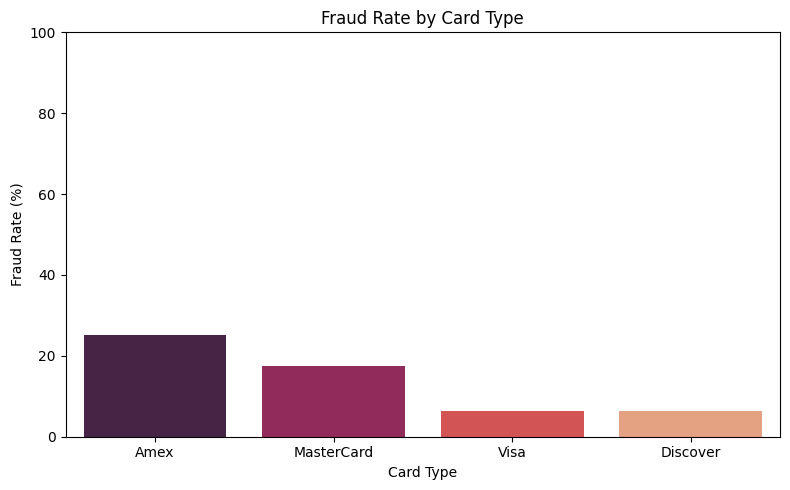

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
#sns.barplot(data=df, x="Card_Type", y="fraud_rate_percent", palette="magma")
sns.barplot(data=df, x="Card_Type", y="fraud_rate_percent", hue="Card_Type", palette="rocket", legend=False)
plt.title("Fraud Rate by Card Type")
plt.ylabel("Fraud Rate (%)")
plt.xlabel("Card Type")
plt.ylim(0, 100)  # since we're working in percentages
plt.tight_layout()
plt.show()


## Top Suspicious Devices

In [9]:
df = con.sql("""
SELECT
  CASE 
    WHEN Device LIKE '%Opera%' THEN 'Opera'
    WHEN Device LIKE '%Linux%' THEN 'Linux'
    WHEN Device LIKE '%iPad%' THEN 'iPad'
    WHEN Device LIKE '%Windows%' THEN 'Windows'
    ELSE 'Other'
  END AS device_type,
  COUNT(*) AS total,
  SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS fraud_count,
  ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate
FROM fraud_data
GROUP BY device_type
ORDER BY fraud_rate DESC
LIMIT 10;
""").df()
df

,device_type,total,fraud_count,fraud_rate
0,Opera,19883,6003.0,30.19
1,Linux,12129,3555.0,29.31
2,Windows,34708,2247.0,6.47
3,Other,29280,1818.0,6.21
4,iPad,4000,236.0,5.90


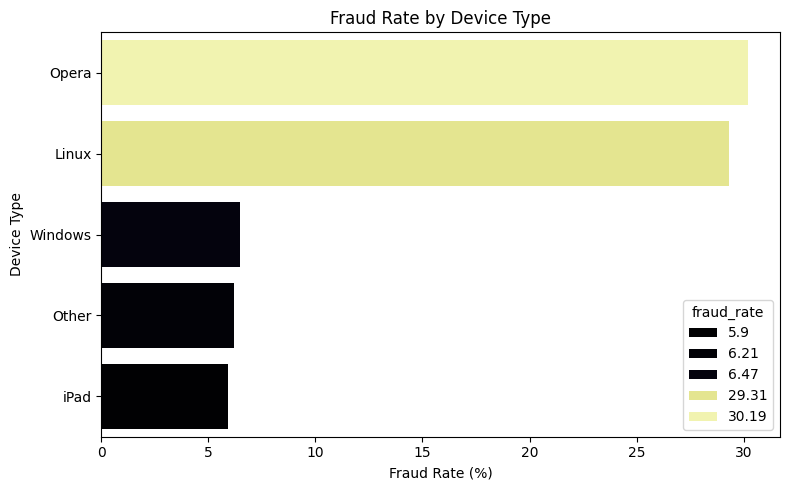

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="fraud_rate", y="device_type", hue="fraud_rate", palette="inferno")
plt.title("Fraud Rate by Device Type")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Device Type")
plt.tight_layout()
plt.show()


## Credit Score vs Fraud Rate Buckets


In [11]:
# Credit Score vs Fraud Rate Buckets

df = con.sql("""SELECT
  CASE
    WHEN Credit_Score < 400 THEN 'Very Low'
    WHEN Credit_Score < 550 THEN 'Low'
    WHEN Credit_Score < 700 THEN 'Medium'
    ELSE 'High'
  END AS credit_bucket,
  COUNT(*) AS total,
  SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) AS frauds,
  ROUND(100.0 * SUM(CASE WHEN Fraudulent THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_percent
FROM fraud_data
GROUP BY credit_bucket
ORDER BY credit_bucket;""").df()

In [103]:
print(df)

  credit_bucket  total  frauds  fraud_rate_percent
0          High  27573  2776.0               10.07
1           Low  27175  4529.0               16.67
2        Medium  27045  2906.0               10.75
3      Very Low  18207  3428.0               18.83


### *More Examples:*

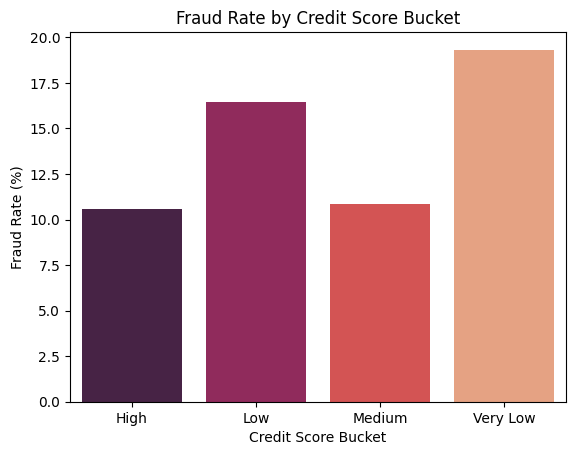

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df, x="credit_bucket", y="fraud_rate_percent", hue="credit_bucket", palette="rocket", legend=False)
plt.title("Fraud Rate by Credit Score Bucket")
plt.ylabel("Fraud Rate (%)")
plt.xlabel("Credit Score Bucket")
plt.show()


### Grouped Bar Chart – Total vs. Fraud Count
Use case: Compare volume of users vs. frauds in each bucket.

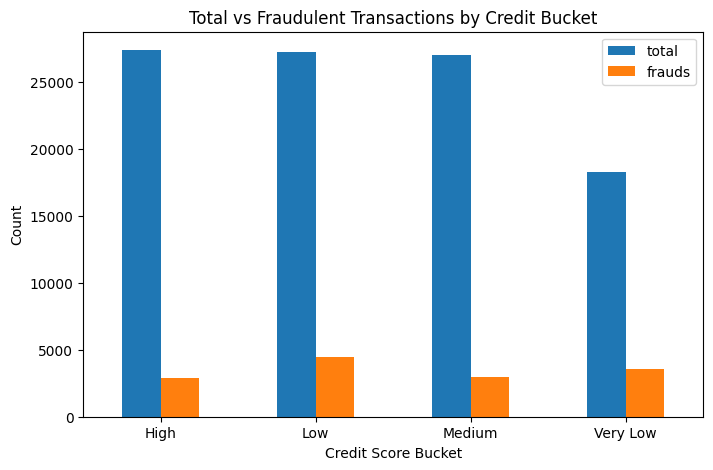

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot = df.set_index("credit_bucket")[["total", "frauds"]]
df_plot.plot(kind="bar", figsize=(8, 5))
plt.title("Total vs Fraudulent Transactions by Credit Bucket")
plt.ylabel("Count")
plt.xlabel("Credit Score Bucket")
plt.xticks(rotation=0)
plt.show()


#### Line Chart

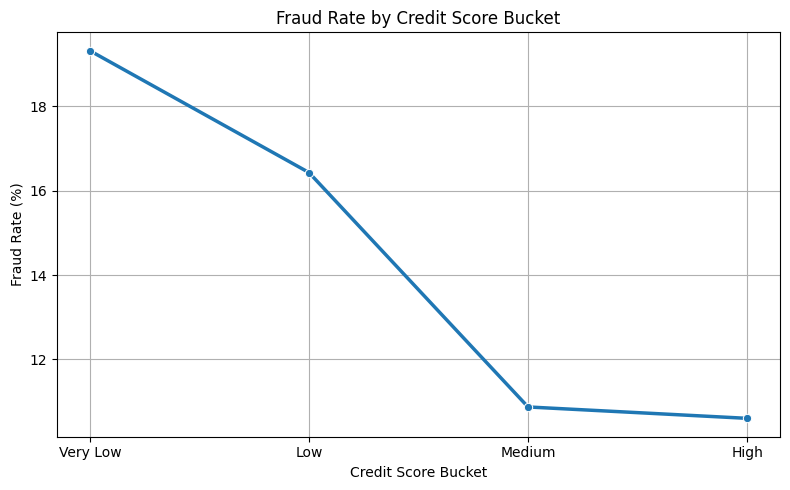

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the buckets are ordered correctly
bucket_order = ["Very Low", "Low", "Medium", "High"]
df["credit_bucket"] = pd.Categorical(df["credit_bucket"], categories=bucket_order, ordered=True)
df = df.sort_values("credit_bucket")

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="credit_bucket", y="fraud_rate_percent", marker="o", linewidth=2.5)
plt.title("Fraud Rate by Credit Score Bucket")
plt.xlabel("Credit Score Bucket")
plt.ylabel("Fraud Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Annotated Text Table or Heatmap
**Use case:** You want to build a reporting table with percentage overlays.

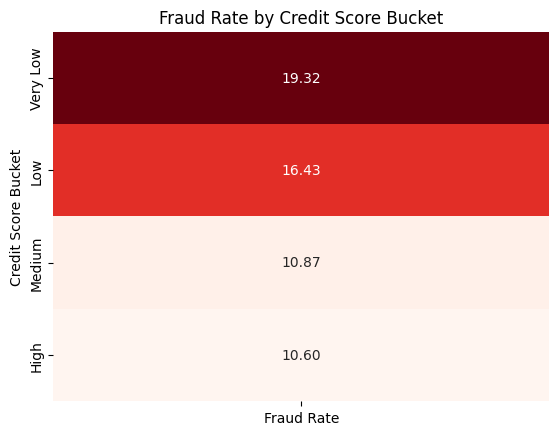

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dummy column to make it 2D.  Not best practice just for demo
df["dummy"] = "Fraud Rate"

# Pivot properly with index, columns, and values
pivot = df.pivot(index="credit_bucket", columns="dummy", values="fraud_rate_percent")

# Plot
sns.heatmap(pivot, annot=True, cmap="Reds", cbar=False, fmt=".2f")
plt.title("Fraud Rate by Credit Score Bucket")
plt.xlabel("")  # Clean up axis label
plt.ylabel("Credit Score Bucket")
plt.show()

### Here are a few others: 

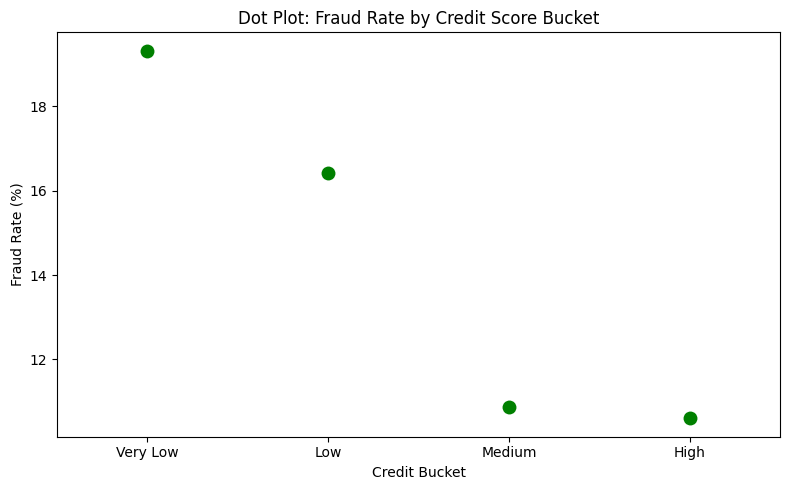

In [16]:
    plt.figure(figsize=(8, 5))
    sns.stripplot(data=df, x="credit_bucket", y="fraud_rate_percent", size=10, color="green")
    plt.title("Dot Plot: Fraud Rate by Credit Score Bucket")
    plt.xlabel("Credit Bucket")
    plt.ylabel("Fraud Rate (%)")
    plt.tight_layout()
    plt.show()


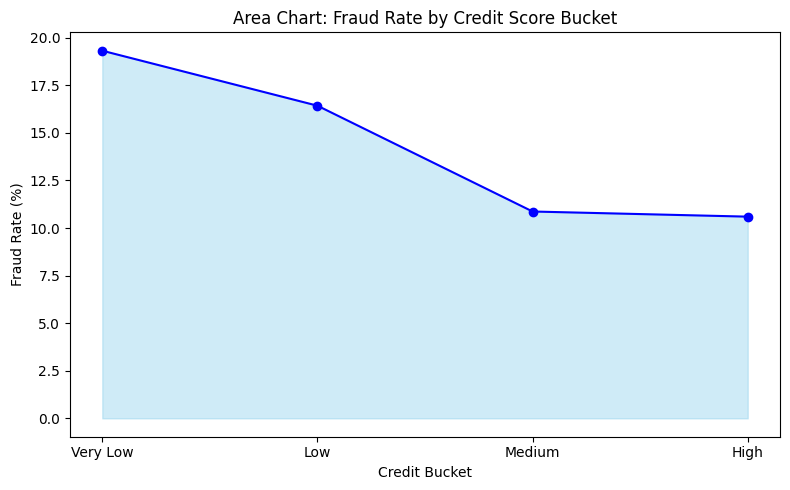

In [17]:
    order = ["Very Low", "Low", "Medium", "High"]
    df["credit_bucket"] = pd.Categorical(df["credit_bucket"], categories=order, ordered=True)
    df = df.sort_values("credit_bucket")

    plt.figure(figsize=(8, 5))
    plt.fill_between(df["credit_bucket"], df["fraud_rate_percent"], alpha=0.4, color="skyblue")
    plt.plot(df["credit_bucket"], df["fraud_rate_percent"], color="blue", marker="o")
    plt.title("Area Chart: Fraud Rate by Credit Score Bucket")
    plt.xlabel("Credit Bucket")
    plt.ylabel("Fraud Rate (%)")
    plt.tight_layout()
    plt.show()

# Lets focus on another domain: Churn